In [1]:
import pandas as pd
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, fixed, ToggleButtons, IntSlider, FloatSlider, Dropdown
%matplotlib inline

# Define model (adjusted from IN's)

In [2]:
def model_afgeleiden(variables, t, beta, gamma):

    S = variables[0]
    I = variables[1]
    R = variables[2]
    
    S_new = -beta*I*S 
    I_new = beta*I*S - gamma*I
    R_new = gamma*I
    return [S_new, I_new, R_new]

def SIRmodel(tijdstappen, S_0, I_0, R_0, beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(beta, gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        modeloutput.plot()
    if returnDataFrame:
        return modeloutput 

# Load total infected from JHU

In [83]:
baseURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/"

In [135]:
def loadData(fileName):
    data = pd.read_csv(baseURL + fileName) \
             .drop(['Lat', 'Long'], axis=1) #\
#              .melt(id_vars=['Province/State', 'Country/Region'], 
#                  var_name='date', value_name=columnName) \
#              .astype({'date':'datetime64[ns]', columnName:'Int64'}, 
#                  errors='ignore')
    data['Province/State'].fillna('<all>', inplace=True)
#     data[columnName].fillna(0, inplace=True)
    return data

In [351]:
Confirmed = loadData(
     "time_series_covid19_confirmed_global.csv")

#     "time_series_covid19_deaths_global.csv", "CumDeaths")) \
#   .merge(loadData(
#     "time_series_covid19_recovered_global.csv", "CumRecovered"))

In [352]:
Confirmed

,Province/State,Country/Region,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20
0,<all>,Afghanistan,0,0,0,0,0,0,0,0,...,24,24,40,40,74,84,94,110,110,120
1,<all>,Albania,0,0,0,0,0,0,0,0,...,70,76,89,104,123,146,174,186,197,212
2,<all>,Algeria,0,0,0,0,0,0,0,0,...,90,139,201,230,264,302,367,409,454,511
3,<all>,Andorra,0,0,0,0,0,0,0,0,...,75,88,113,133,164,188,224,267,308,334
4,<all>,Angola,0,0,0,0,0,0,0,0,...,1,2,2,3,3,3,4,4,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,<all>,Burma,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,8,8,10
249,Anguilla,United Kingdom,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
250,British Virgin Islands,United Kingdom,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
251,Turks and Caicos Islands,United Kingdom,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,4,4


In [166]:
COVID19_totalConf = pd.DataFrame(Confirmed.T[4:].sum(axis=1), columns=['TotalConfirmed'])

In [167]:
COVID19_totalConf.index = pd.to_datetime(COVID19_totalConf.index)

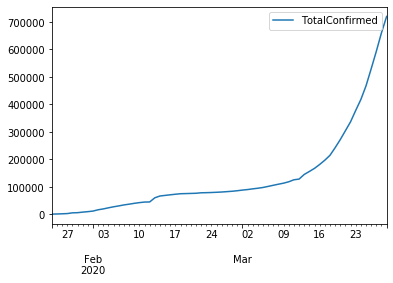

In [170]:
COVID19_totalConf.plot();

## SIR model on global data

In [171]:
def SIRmodel_logbeta(tijdstappen, S_0, I_0, R_0, log10_beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,10))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(COVID19_totalConf, 'rx')
        axes.plot(modeloutput);
#         modeloutput.plot()
        
    if returnDataFrame:
        return modeloutput 

In [172]:
# fig, axes = plt.subplots(1,1)
# axes.set_xlabel('time')
# axes.set_ylabel('Population')

interact(SIRmodel_logbeta, 
         tijdstappen=fixed(np.arange(0., 1000, 1)), 
         COVID19_totalConf=COVID19_totalConf,
                   S_0=FloatSlider(value=2*COVID19_totalConf.max()[0], 
                                   min=1.5*COVID19_totalConf.max()[0], 
                                   max=5000000, 
                                   step=100000,
                                   continuous_update=False, readout_format='.2e'), 
                   I_0=fixed(1), R_0=fixed(0),
                   log10_beta=FloatSlider(value=-7, min=-8, max=-6, step=0.001,
                                    continuous_update=True, readout_format='.2e'),
                   gamma=FloatSlider(value=0.01, min=0, max=0.05, step=0.001,
                                     continuous_update=False, readout_format='.2e'),
                   returnDataFrame=fixed(False));
# axes.plot(COVID19_totalConf, 'rx')

interactive(children=(FloatSlider(value=1440234.0, continuous_update=False, description='S_0', max=5000000.0, …

## Rework JHU data

In [353]:
Confirmed = Confirmed.groupby(['Country/Region']).sum()

In [354]:
Confirmed = Confirmed.T

In [355]:
Confirmed.max().idxmax()

'US'

In [358]:
Confirmed.index = pd.to_datetime(Confirmed.index)

140886


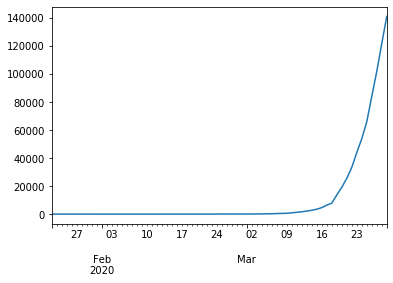

In [359]:
Confirmed[Confirmed.max().idxmax()].plot()
print(str(max(Confirmed['US'])))

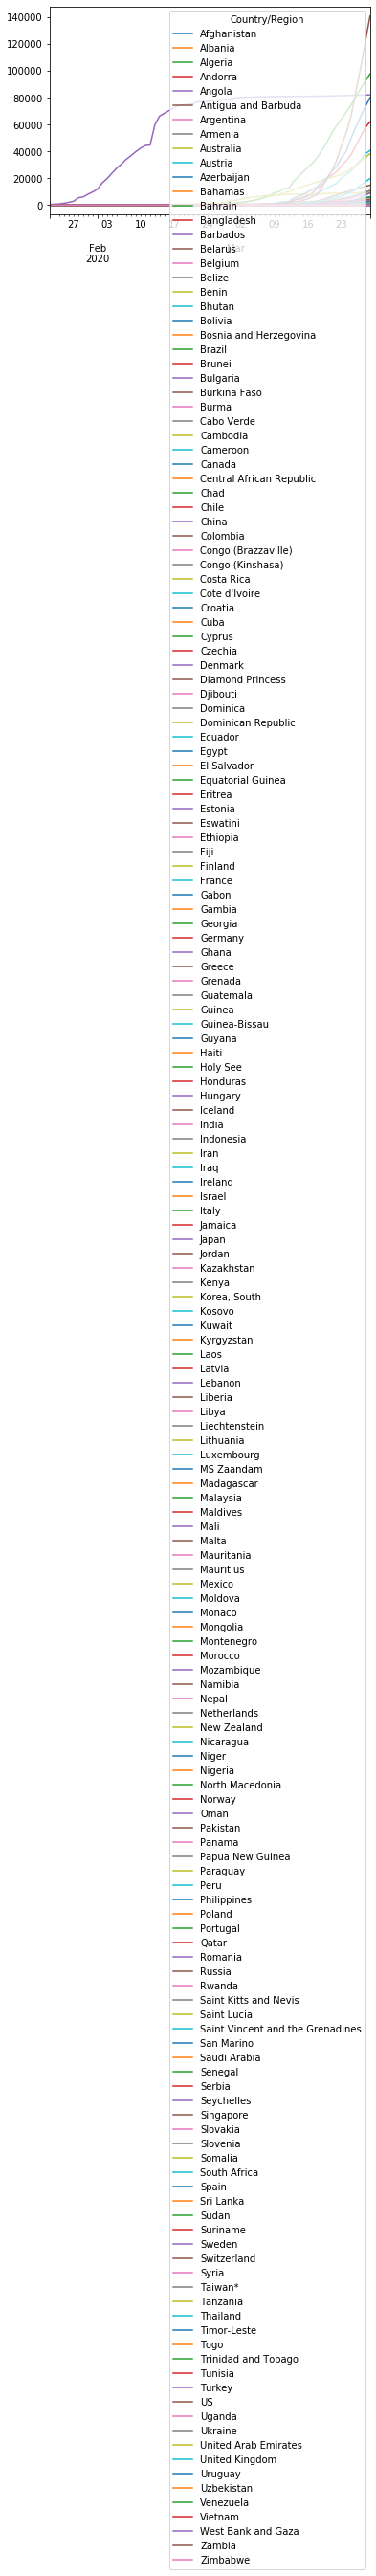

In [360]:
Confirmed.plot()

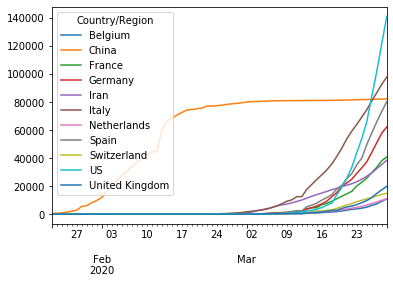

In [361]:
Confirmed[Confirmed.columns[Confirmed.max()>10000]].plot()

In [362]:
ConfirmedMax = pd.DataFrame(data={'Country': Confirmed.columns, 'cum_cases': Confirmed.max().values})

In [363]:
ConfirmedMax = ConfirmedMax.set_index('Country')

In [364]:
ConfirmedMax['Rank'] = ConfirmedMax.rank(ascending=0)

In [365]:
ConfirmedMax = ConfirmedMax.reset_index()
ConfirmedMax = ConfirmedMax.set_index('Rank')

In [366]:
ConfirmedMax.sort_index(ascending=True).head(10)

,Country,cum_cases
Rank,,
1.0,US,140886
2.0,Italy,97689
3.0,China,82122
4.0,Spain,80110
5.0,Germany,62095
6.0,France,40708
7.0,Iran,38309
8.0,United Kingdom,19780
9.0,Switzerland,14829


In [367]:
top10 = ConfirmedMax.sort_index(ascending=True).head(10).reset_index()['Country']

In [368]:
top10

0                US
1             Italy
2             China
3             Spain
4           Germany
5            France
6              Iran
7    United Kingdom
8       Switzerland
9       Netherlands
Name: Country, dtype: object

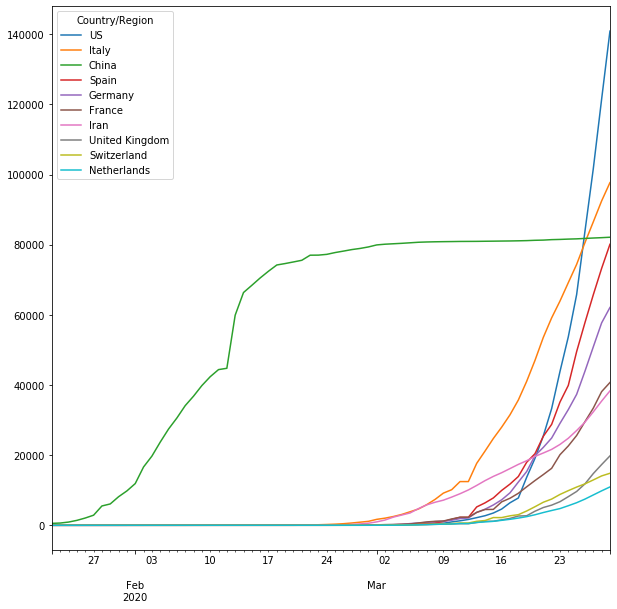

In [369]:
Confirmed[top10].plot(figsize=(10,10));

## Country specific SIR model

In [374]:
def SIRmodel_logbeta2(timesteps, S_0, I_0, R_0, log10_beta, gamma, measured_cases, country, returnDataFrame=True, plotFig=True):
    """
    SIR population model implementation
    
    Parameters
    -----------
    timesteps : np.array
    country: string
    
    
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], timesteps, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=timesteps)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(timesteps))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,10))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(measured_cases[country], 'rx')
        axes.plot(modeloutput);
#         measured_cases[country].plot(axes=axes)
        
    if returnDataFrame:
        return modeloutput 

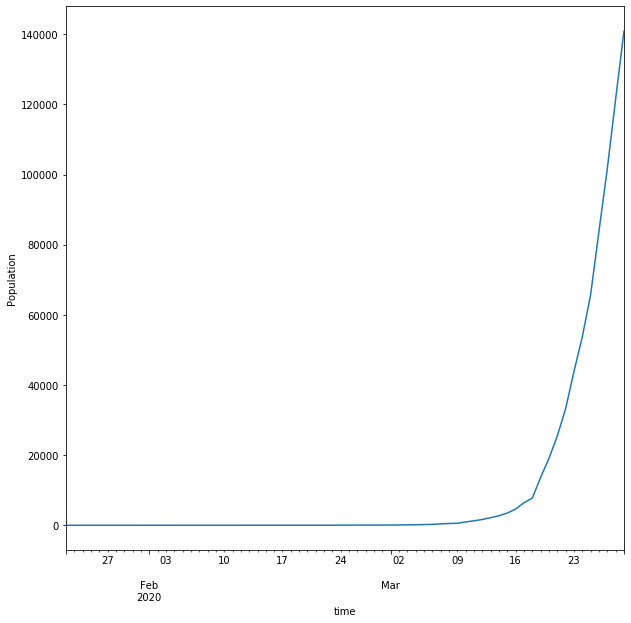

In [372]:
fig, axes = plt.subplots(1,1, figsize=(10,10))
axes.set_xlabel('time')
axes.set_ylabel('Population')

# axes.plot(pd.DataFrame(Confirmed['US'], index=Confirmed.index), 'rx')
Confirmed['US'].plot(axes=axes)
#         axes.plot(modeloutput);

In [375]:
# fig, axes = plt.subplots(1,1)
# axes.set_xlabel('time')
# axes.set_ylabel('Population')

interact(SIRmodel_logbeta2, 
         
         timesteps=fixed(np.arange(0., 1000, 1)), 
         
         country = Dropdown(options=list(Confirmed.columns), value='US'),
         
         measured_cases = fixed(Confirmed),
         
         S_0=FloatSlider(value=2*Confirmed.max().max(), 
                           min=Confirmed.max().max(), 
                           max=10*Confirmed.max().max(), 
                           step=1000,
                           continuous_update=False, readout_format='.2e'), 
         I_0=fixed(1), R_0=fixed(0),
         
         log10_beta=FloatSlider(value=-7, min=-8, max=-6, step=0.001,
                                continuous_update=True, readout_format='.2e'),
         
         gamma=FloatSlider(value=0.01, min=0, max=0.05, step=0.001,
                           continuous_update=False, readout_format='.2e'),
         returnDataFrame=fixed(False));
# axes.plot(COVID19_totalConf, 'rx')

interactive(children=(FloatSlider(value=281772.0, continuous_update=False, description='S_0', max=1408860.0, m…

# Cases in Italy

Inspired by https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d)

In [376]:
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve

In [377]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

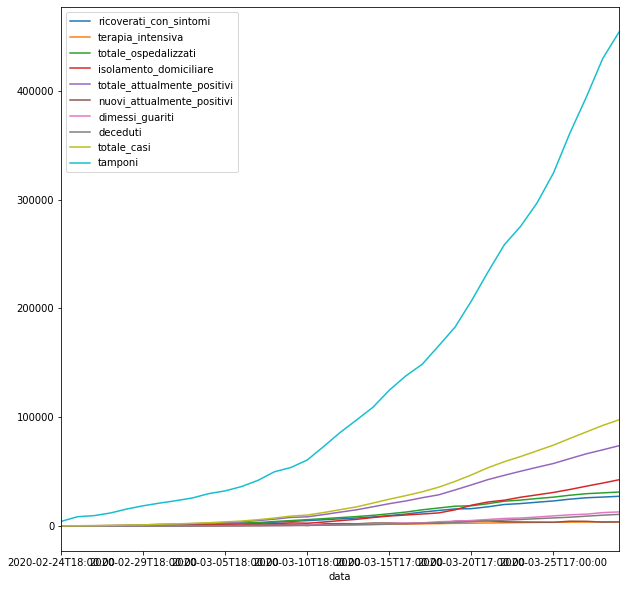

In [378]:
df.set_index('data').plot(figsize=(10,10));

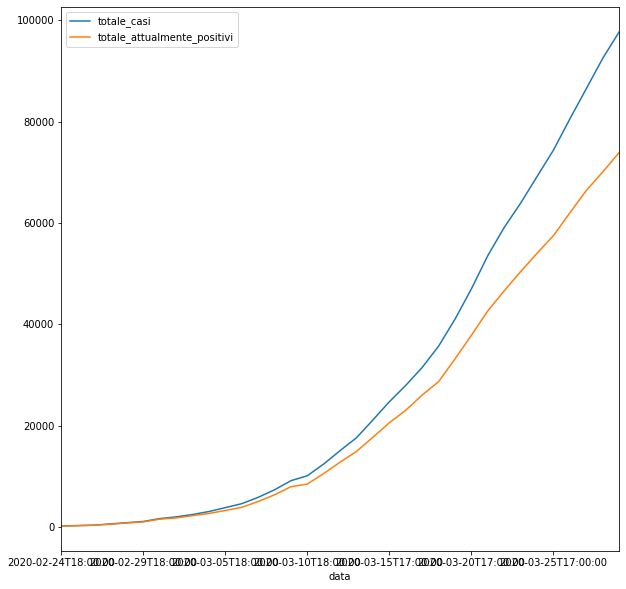

In [379]:
df.set_index('data')[['totale_casi', 'totale_attualmente_positivi']].plot(figsize=(10,10));

In [382]:
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))

In [384]:
x = list(df.index)
y = list(df['totale_casi'].values)
fit = curve_fit(logistic_model, x, y,p0=[5,100,2000])

In [385]:
errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]

In [386]:
a = fit[0][0]
b = fit[0][1]
c = fit[0][2]
print('Coeff is '+str(round(a)))
print('Coeff is '+str(round(b)))
print('Total predicted infected '+str(round(c))+ ' +-'+str(round(errors[2])))

Coeff is 5.0
Coeff is 28.0
Total predicted infected 128479.0 +-2202.0


In [387]:
sol = int(fsolve(lambda x : logistic_model(x,a,b,c) - int(c),b))

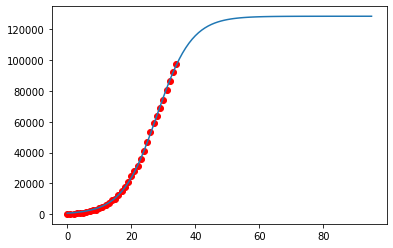

In [388]:
pred_x = list(range(max(x),sol))
# plt.rcParams['figure.figsize'] = [7, 7]
# plt.rc('font', size=14)
# Real data
plt.scatter(x,y, label="Real data",color="red")
# Predicted logistic curve
plt.plot(x+pred_x, [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x], label="Logistic model" );

In [389]:
preddf = pd.DataFrame([pd.to_datetime(df['data'][0]) + pd.to_timedelta(x+pred_x, unit='D'), 
                       [logistic_model(i,fit[0][0],fit[0][1],fit[0][2]) for i in x+pred_x]]).T
preddf.columns = ['data', 'totale_casi']
preddf = preddf.set_index('data')

In [390]:
dftotale = pd.DataFrame(df.set_index('data')['totale_casi'])
dftotale.index = pd.to_datetime(dftotale.index)

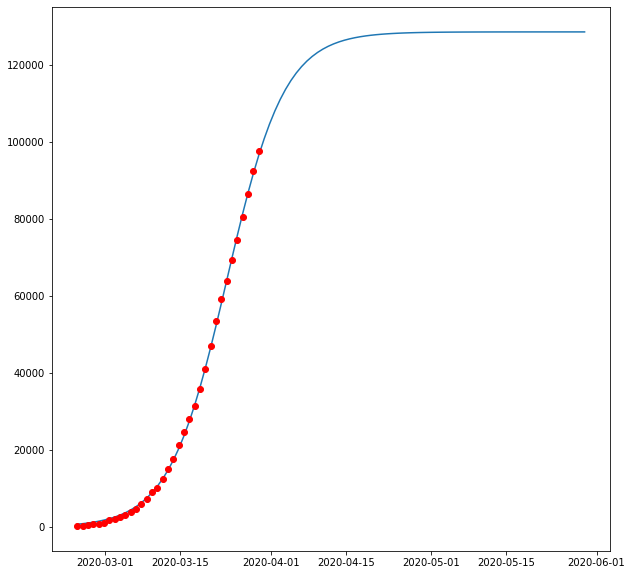

In [391]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

ax.plot(preddf)
ax.plot(dftotale, 'or');

In [392]:
def SIRmodel_logbeta(tijdstappen, S_0, I_0, R_0, log10_beta, gamma, returnDataFrame=True, plotFig=True):
    """
    Modelimplementatie van het populatiemodel 
    
    Parameters
    -----------
    tijdstappen : np.array
        array van tijdstappen          
    """
    modeloutput = odeint(model_afgeleiden, [S_0, I_0, R_0], tijdstappen, args=(10**(log10_beta), gamma));
    modeloutput = pd.DataFrame(modeloutput, columns=['S','I','R'], index=tijdstappen)
    
    modeloutput.index = pd.date_range(start='11/1/2019', periods=len(tijdstappen))
    
    if plotFig:
        fig, axes = plt.subplots(1,1, figsize=(10,10))
        axes.set_xlabel('time')
        axes.set_ylabel('Population')

        axes.plot(dftotale, 'rx')
        axes.plot(modeloutput);
#         modeloutput.plot()
        
    if returnDataFrame:
        return modeloutput 

In [393]:

interact(SIRmodel_logbeta, 
         tijdstappen=fixed(np.arange(0., 1000, 1)), 
         COVID19_totalConf=COVID19_totalConf,
                   S_0=FloatSlider(value=c, 
                                   min=0.5*c, 
                                   max=10*c, 
                                   step=c/1000,
                                   continuous_update=False, readout_format='.2e'), 
                   I_0=fixed(1), R_0=fixed(0),
                   log10_beta=FloatSlider(value=-6.5, min=-8, max=-5, step=0.0001,
                                    continuous_update=True, readout_format='.2e'),
                   gamma=FloatSlider(value=0.03, min=0, max=0.05, step=0.001,
                                     continuous_update=False, readout_format='.2e'),
                   returnDataFrame=fixed(False));

interactive(children=(FloatSlider(value=128479.38308930819, continuous_update=False, description='S_0', max=12…

# New visualization

Inspired by https://t.co/q2AtUQBX5P?amp=1

In [413]:
top10

0                US
1             Italy
2             China
3             Spain
4           Germany
5            France
6              Iran
7    United Kingdom
8       Switzerland
9       Netherlands
Name: Country, dtype: object

In [430]:
from pandas.tseries.offsets import Week
res = (Confirmed - Confirmed.shift(1, freq=Week()).reindex(Confirmed.index)).fillna(value=0)

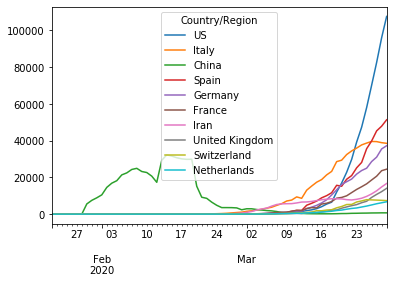

In [449]:
res[top10].plot()

In [456]:
top10

0                US
1             Italy
2             China
3             Spain
4           Germany
5            France
6              Iran
7    United Kingdom
8       Switzerland
9       Netherlands
Name: Country, dtype: object

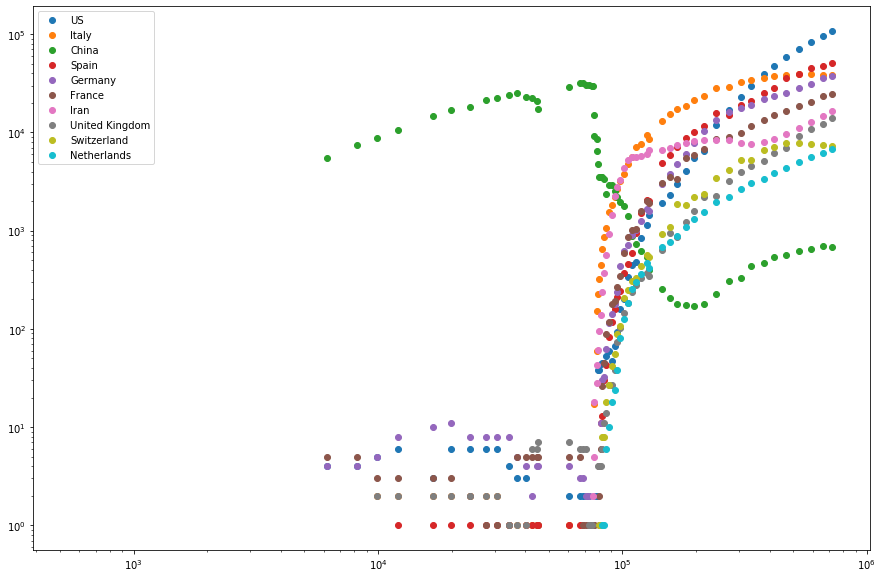

In [535]:
fig, axes = plt.subplots(figsize=(15,10))
for i in top10:
    
    df = pd.DataFrame([res[i].values, ConfirmedGlobal.values]).T

    axes.loglog(df[1], df[0], 'o')
    axes.legend(top10)

    

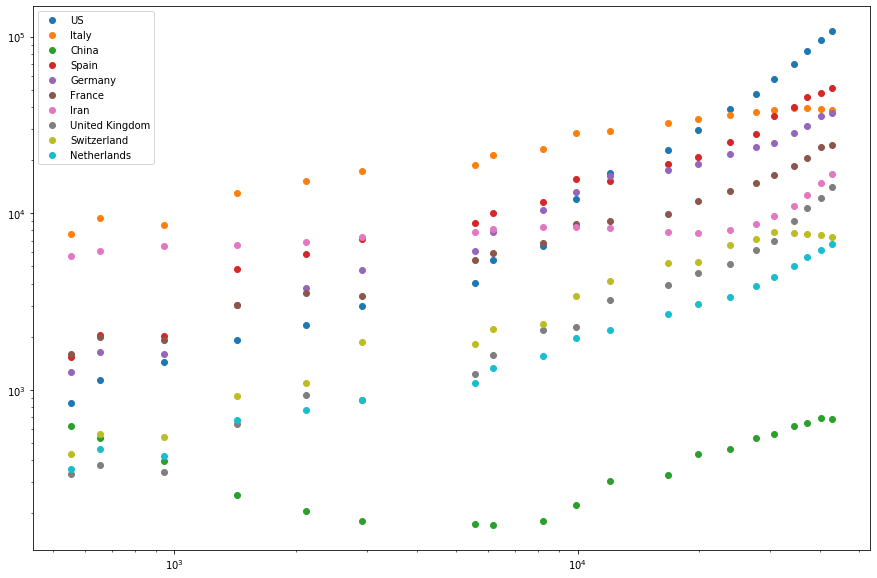

In [541]:
fig, axes = plt.subplots(figsize=(15,10))
for i in top10:
    
    df = pd.DataFrame([res['2020-03-10':'2020-03-30'][i].values, ConfirmedGlobal.values]).T

    axes.loglog(df[1], df[0], 'o')
    axes.legend(top10)

    

In [560]:
def newplot(growthrate, countries, ConfirmedGlobal):
    
    fig, axes = plt.subplots()
    for i in countries:

        df = pd.DataFrame([growthrate[i].values, ConfirmedGlobal.values]).T

        axes.loglog(df[1], df[0], 'o')
        axes.legend(countries)

    

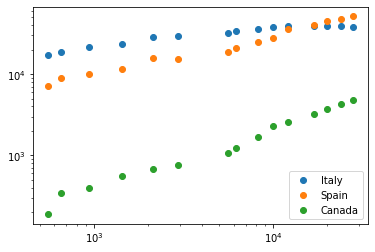

In [561]:
newplot(res['2020-03-15':], ['Italy', 'Spain', 'Canada'], ConfirmedGlobal)